In [1]:
from larch import Group
from larch.xafs import feffit, feffit_dataset, feffit_transform, feffit_report
from larch.xafs import autobk, xftf, xftr, ff2chi, feffpath
from larch.fitting import  param_group, param
from larch.io import read_ascii

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

[root] WARNING : Larchs apps and shell are not supported due to missing dependencies: cannot import name 'LarchWxApp' from 'larch.wxlib' (D:\Python\Anaconda3\envs\xraylarch\lib\site-packages\larch\wxlib\__init__.py)


In [2]:
""" Cu Standard Fitting. 

--- Data Reading and Pre-processing ---

Notes: 
1.  Data is read from .nxs file and loaded into a larch group from scratch.

2.  The data loaded was normalised via DAWN. To suppress auto-normalisation in Larch, 
    the pre_edge_kws are added to force a 0th degree polynomial fit for post-edge.
    
WIP: define data directly as normalised data

"""
file_path = "data\\exafs_fitting\\Cu_foil_STD_merge_norm.nxs" # Normalised .nxs file

# Reading .nxs by h5py
file = h5py.File(file_path, "r")
energy = np.array(file["processed"]["result"]["energy"])
data = np.array(file["processed"]["result"]["data"])

# Loading into a larch group and autobk (see note 2)
std_cu = Group(name="Cu Standard", energy=energy, mu=data)
autobk(std_cu, pre_edge_kws={"nnorm": 0, "nvict": 0}, rbkg=1.0) 

Text(0, 0.5, 'Absorption')

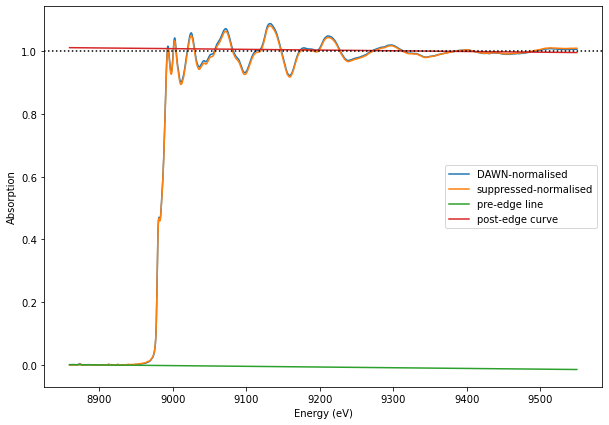

In [3]:
""" Misc: Inspecting the suppressed normalisation result. """
energy = std_cu.energy

fig = plt.figure(figsize=(10, 7))

plt.plot(energy, std_cu.mu, label='DAWN-normalised')
plt.plot(energy, std_cu.norm, label='suppressed-normalised')
plt.plot(energy, std_cu.pre_edge, label='pre-edge line')
plt.plot(energy, std_cu.post_edge, label='post-edge curve')
plt.axhline(1, linestyle=":", color="k")

plt.legend()
plt.xlabel("Energy (eV)")
plt.ylabel("Absorption")

In [4]:
""" Ready scattering path files. """

folder_path = "C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/"
file_list = [os.path.join(folder_path, path) for path in os.listdir(folder_path) if "feff00" in path]

In [5]:
""" Set up feffit for EXAFS Fitting. """

# Define Fourier transform and fitting space (Actual FT parameters for EXAFS fitting)
_feffit_trans = feffit_transform(kmin=3.000, kmax=10.000, dk=1.0000, kw=2,
                                 window="hanning", fitspace='r', rmin=1.000, rmax=6.000)


# Create feffit Parameter Group to hold fit parameters (Core parameters)
_feffit_params = param_group(s02=param(1.0, min=0, vary=True),
                             e0=param(0.1, min=-25, max=25, vary=True))

# Create feffit Parameter Group to hold fit parameters (Repeating parameters)
scatter_paths = file_list[:11]
ncucu_theory = [12, 6, 48, 48, 24, 48, 96, 12, 12, 24, 12, 12, 12]
path_num = len(scatter_paths)

fit_params = ["n_cucu", "delr_cu", "sigma2_cu"]
def fit_constraints(n_cucu):
    constraints = [param(n_cucu, vary=False),
                   param(0.001, min=-0.5, max=0.5, vary=True),
                   param(0.008, min=0.001, max=0.009, vary=True)]
    
    return constraints

all_fit_params = [param + str(i) for i in range(path_num) for param in fit_params]
all_fit_constraints = [fit_constraints(ncucu) for i, ncucu in zip(range(path_num), ncucu_theory)]

all_fit_cons = [element for element1 in all_fit_constraints for element in element1] # need better naming

for key, value in zip(all_fit_params, all_fit_cons):
    setattr(_feffit_params, key, value)


In [6]:
_paths_dict = {}

def generate_feffpath(file_path, label, degen, e0, sigma2, s02, deltar):
    return feffpath(file_path, label=label, degen=degen, e0=e0, sigma2=sigma2, s02=s02, deltar=deltar)
    
for i, scatter_path in enumerate(scatter_paths):
    _paths_dict["Cu" + str(i)] = generate_feffpath(scatter_path,
                                                   label="Cu"+str(i),
                                                   degen=1,
                                                   e0="e0",
                                                   sigma2="sigma2_cu"+str(i),
                                                   s02="s02 * n_cucu"+str(i),
                                                   deltar="delr_cu"+str(i))

_paths_dict

{'Cu0': <FeffPath Group label=Cu0, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0001.dat>,
 'Cu1': <FeffPath Group label=Cu1, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0002.dat>,
 'Cu2': <FeffPath Group label=Cu2, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0003.dat>,
 'Cu3': <FeffPath Group label=Cu3, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0004.dat>,
 'Cu4': <FeffPath Group label=Cu4, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0005.dat>,
 'Cu5': <FeffPath Group label=Cu5, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0006.dat>,
 'Cu6': <FeffPath Group label=Cu6, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0007.dat>,
 'Cu7': <FeffPath Group label=Cu7, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0008.dat>,
 'Cu8': <FeffPath Group label=Cu8, filename=C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0009.dat>,
 'Cu9': <FeffPath Group label=Cu9, filename=C:

In [7]:
# Build feffit dataset, run feffit
_feffit_dataset = feffit_dataset(data=std_cu, transform=_feffit_trans, paths=_paths_dict)
_feffit_result = feffit(_feffit_params, _feffit_dataset)

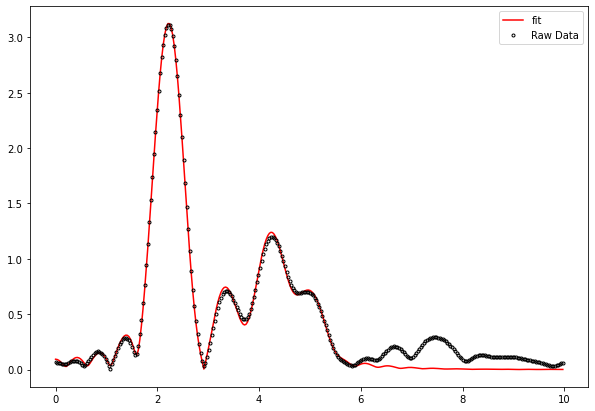

In [8]:
""" Misc: Plotting fitted spectra

All (meta)data is stored within the _feffit_result group.

"""

fig = plt.figure(figsize=(10, 7))

data_r = _feffit_dataset.data.r
data_chir_mag = _feffit_dataset.data.chir_mag

fit_r = _feffit_dataset.model.r
fit_chir_mag = _feffit_dataset.model.chir_mag

plt.plot(fit_r, fit_chir_mag, color="r", label="fit")
plt.plot(data_r, data_chir_mag, lw=0, marker='o', markersize=3, fillstyle='none', color="k", label="Raw Data")
plt.legend()

In [9]:
""" 
Misc: Print fitted results.

Larch also organises the fitting results in a "feffit_report" as shown below.

"""
print(feffit_report(_feffit_result))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  24, 326
   n_independent      =  23.282
   chi_square         =  256.825090
   reduced chi_square = -357.541754
   r-factor           =  9.4392e-04
   Akaike info crit   =  103.893009
   Bayesian info crit =  131.437024
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.000, 6.000
   k-range            = 3.000, 10.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0001.dat', 'C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0002.dat', 'C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0003.dat', 'C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0004.dat', 'C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0005.dat', 'C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0006.dat', 'C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0007.dat', 'C:/Users/user/larch/feff/Cu1_K_Copper_cif11145/feff0008.dat', 

In [10]:
"""
Misc: Fitted Parameters

Most fitted parameters are stored within _feffit_result.params, which is a "Parameters" object from the lmfit package.
See example below for extracting fitted parameters.

"""

results = _feffit_result

# Example to extract fitted parameters
label = "s02"
s02 = results.params[label].value
s02_err = results.params[label].stderr

print("---- Fitted Parameters ----")
print(label, ":", s02, "; error: ", s02_err)

# Show lmfit Parameters object
results.params

---- Fitted Parameters ----
s02 : 0.9072422041263053 ; error:  None


name,value,initial value,min,max,vary,expression
delr_cu0,-0.00894108,0.001,-0.50000000,0.50000000,True,
delr_cu1,-0.03877862,0.001,-0.50000000,0.50000000,True,
delr_cu10,-0.43246436,0.001,-0.50000000,0.50000000,True,
delr_cu2,-0.07964022,0.001,-0.50000000,0.50000000,True,
delr_cu3,-0.30893761,0.001,-0.50000000,0.50000000,True,
delr_cu4,0.03575412,0.001,-0.50000000,0.50000000,True,
delr_cu5,-0.15778139,0.001,-0.50000000,0.50000000,True,
delr_cu6,0.02198367,0.001,-0.50000000,0.50000000,True,
delr_cu7,0.07245175,0.001,-0.50000000,0.50000000,True,
delr_cu8,-0.00624098,0.001,-0.50000000,0.50000000,True,
